<a href="https://colab.research.google.com/github/Tahimi/convectionDiffusion/blob/main/lagoAdvectionDiffusionSource2D_FipyFiniteVolume.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install fipy Gmsh
# uncomment to install fipy, restart (runtime env.) and execute all

In [2]:
# authorize Colab to access and mount the Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import numpy as np
from fipy import *

In [4]:
# space discretization
geoFileName = '/content/drive/MyDrive/UFAL/advection_diffusion/FiniteDiference_FipyFiniteVolume/lagoGeoFileForGmsh.geo.txt'
mesh = Gmsh2D(geoFileName)
dx = 60 # m
print('cellsNbr = ', mesh.globalNumberOfCells)

cellsNbr =  6377


In [5]:
# time discretization
# advection
vx = vy = 2. # m/s
Cr = 0.8 # Courant Number: Cr = u*dt/dx
dtAdv = abs(Cr*dx/max(vx,vy))
# diffusion
Fr = 0.5 # Fourier Number: Fr = D*dt/dx**2
D = 20.
dtDiff = abs(Fr*dx**2/D)
# advectionDiffusion
dt = min(dtAdv,dtDiff)
delT = 60. # sec
stepsNbr = int(delT/dt)

In [6]:
def sourceCenter(sourcePos):
    global mesh
    x, y = mesh.x, mesh.y
    xs1, ys1 = sourcePos
    dist2Source = DistanceVariable(mesh=mesh,
                                   value=numerix.sqrt((x-xs1)**2+(y-ys1)**2))
    sourceClosestCellMask = (dist2Source == dist2Source.min())
    xcs, *_ = x[sourceClosestCellMask]
    ycs, *_ = y[sourceClosestCellMask]
    return (xcs, ycs)

In [7]:
def sourceMask(xcs, ycs, width, isRectangular = False):
    global mesh
    x, y = mesh.x, mesh.y
    # the source shape is rectangular
    if isRectangular:
        return ((xcs-width<x) & (x<xcs+width) \
              & (ycs-width<y) & (y<ycs+width))
    # the source shape is circular
    else:
        ds = DistanceVariable(mesh=mesh,
                              value=numerix.sqrt((x-xcs)**2+(y-ycs)**2))
        return (ds <= width)

In [8]:
# initialization
zMin, zMax = 0., 1.
s1Pos = (1500, 200)
s1Width = 40

def initialize():
    # preparing the SourceTerm
    global s1Pos, s1Width
    xcs1, ycs1 = sourceCenter(s1Pos)
    s1Mask = sourceMask(xcs=xcs1,
                        ycs=ycs1,
                        width=s1Width,
                        isRectangular=False)

    # unkown's initialization
    global mesh, zMin, zMax, zInit, z
    zInit = CellVariable(mesh=mesh, value=zMin)
    zInit.setValue(zMax, where=s1Mask)
    z = CellVariable(mesh=mesh, value=zInit)

    # Applying noFlow BC
    z.faceGrad.constrain((0.,), where=mesh.exteriorFaces)

    # Defining the discritized equation
    global vx, vy, D, eq
    eq = (TransientTerm(coeff=1.0) + PowerLawConvectionTerm(coeff=(vx,vy))
       == DiffusionTerm(coeff=D)
       - ImplicitSourceTerm(s1Mask * 1e+10) + s1Mask * 1e+10 * zMax)

In [9]:
# defining the time-step update function
def advectAndDiffuse1(z, dt):
    eq.solve(var=z, dt=dt)

In [10]:
# display some parameters
print('dx = ', dx, '\n'
      'cellsNbr = ', mesh.globalNumberOfCells, '\n'
      'vx = ', vx, '\n'
      'vy = ', vy, '\n'
      'Cr = ', Cr, '\n'
      'dtAdv = ', dt, '\n'
      'D = ', D, '\n'
      'Fr = ', Fr, '\n'
      'dtDiff = ', dt, '\n'
      'dt = min(dtAdv,dtDiff) = ', dt, '\n'
      'stepsNbr = ', stepsNbr)

dx =  60 
cellsNbr =  6377 
vx =  2.0 
vy =  2.0 
Cr =  0.8 
dtAdv =  24.0 
D =  20.0 
Fr =  0.5 
dtDiff =  24.0 
dt = min(dtAdv,dtDiff) =  24.0 
stepsNbr =  2


In [11]:
# initialize and iterate in time
initialize()
for step in range(stepsNbr):
    advectAndDiffuse1(z, dt)

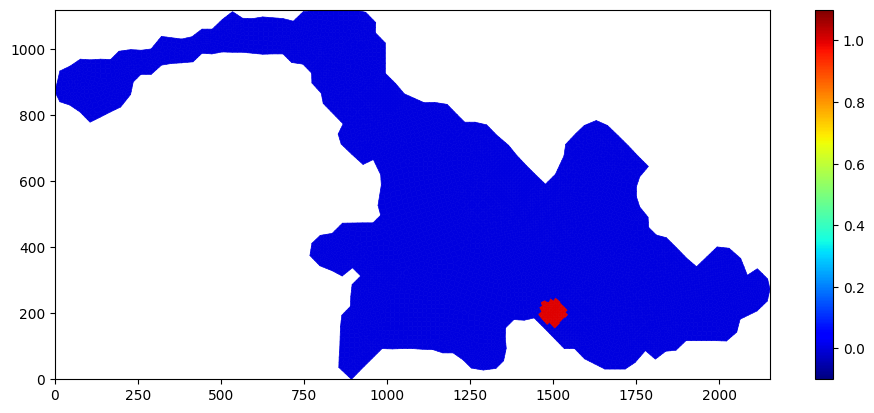

In [12]:
# ploting the unkown's initial distribution
viewer = Viewer(vars = (zInit),
                datamin = zInit.min()-.1,
                datamax = zInit.max()+.1)
viewer.plotMesh()

After 48.0  (sec)


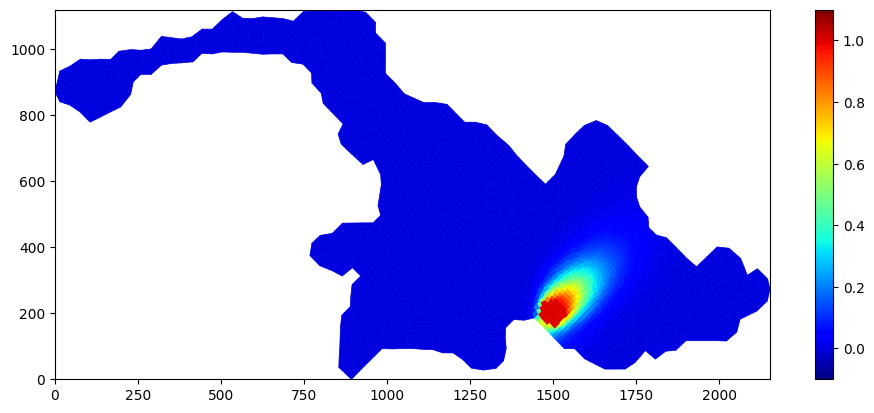

In [13]:
# ploting the unkown's final distribution
print('After', dt*stepsNbr, ' (sec)')
viewer = Viewer(vars = (z),
                datamin = z.min()-.1,
                datamax = z.max()+.1)
viewer.plot()